## Introducción del Trabajo Integrador 

Para la primer parte de este proyecto el objetivo es llevar a la práctica el marco teórico establecido por Vangelista en su paper Frequency Shift Chirp Modulation:
 The LoRa Modulation. Se desarrollará una simulación en software del sistema de comunicación LoRa/FSCM, implementando el codificador Y decodificador de símbolos, el generador de la forma de onda chirp, y el demodulador eficiente basado en FFT. A través de esta simulación, se analizará el rendimiento del sistema bajo dos condiciones de canal descritas en el paper: un canal de ruido aditivo blanco gaussiano (AWGN) y un canal selectivo en frecuencia. El fin último es reproducir las curvas de Tasa de Error de Bits (BER) y Tasa de Error de Simbolo (SER) presentadas en el análisis de rendimiento del paper para verificar los hallazgos teóricos y obtener una comprensión práctica de las fortalezas y debilidades de esta modulación. En la segunda etapa del proyecto, se avanza hacia la implementación de la estructura completa de paquetes LoRa mediante la función de construcción de tramas. Esta funcionalidad resulta fundamental para aproximarse a un sistema de comunicación real.

In [83]:
import numpy as np
import matplotlib.pyplot as plt  

In [84]:
#Variables
Bw = 1
bits_tx = np.random.randint(0,2, size=700)
SF = 7
SF_Validos = [7, 8, 9, 10, 11, 12]
M = 2**SF    # cantidad de muestras por chirp


## CODIFICADOR

###   Ecuación brindada por Vangelista para la implementación del codificador
$s(nT_s) = \sum_{h=0}^{SF-1} w(nT_s)_h \cdot 2^h$
- Objetivo: Convertir un grupo de SF bits en un único número entero (s).
- Realiza una conversión estándar de binario a decimal. Si SF=7, toma 7 bits y los convierte en un número entre 0 y 127. Este número s es la información que se va a modular.
- $s(nT_s)$ Es el simbolo.
- $w(nT_s)$ Es un vector de digitos binarios de largo SF.
#### Ejemplo - Con datos de entrada:

- bits = [1, 0, 0, 1, 1, 1, 0]
- SF = 7

#### Desarrollo paso a paso:

Agrupamos los 7 bits como un único símbolo, ya que SF = 7.

$\begin{aligned}
s &= w_0 \cdot 2^0 + w_1 \cdot 2^1 + w_2 \cdot 2^2 + w_3 \cdot 2^3 + w_4 \cdot 2^4 + w_5 \cdot 2^5 + w_6 \cdot 2^6 \\
  &= 1 \cdot 2^0 + 0 \cdot 2^1 + 0 \cdot 2^2 + 1 \cdot 2^3 + 1 \cdot 2^4 + 1 \cdot 2^5 + 0 \cdot 2^6 \\
  &= 1 \cdot 1 + 0 \cdot 2 + 0 \cdot 4 + 1 \cdot 8 + 1 \cdot 16 + 1 \cdot 32 + 0 \cdot 64 \\
  &= 1 + 0 + 0 + 8 + 16 + 32 + 0 \\
  &= 57
\end{aligned}$


In [85]:

def coder(bits, SF):

    if SF not in SF_Validos:
        raise ValueError("Invalido")
    if len(bits) % SF != 0:
        raise ValueError("Numero de bits no es multiplo de SF")

    N_simbolos = len(bits) // SF   #Division de enteros
    s = np.zeros(N_simbolos, dtype=int)

    for i in range(N_simbolos):
        for h in range(SF):
            s[i] += bits[i * SF + h] * (2 ** h)

    return s

simbolo_tx = coder(bits_tx, SF)
print(simbolo_tx)

[ 29  77 110  48 111  84 110  62 108  40  45  30  64  75  47  66  96  67
   1  33  24   5  36  32 115  71  49   5 107 126 119 103  20 122 125   7
 112  48  22  83  40  98  93 127   3  54  40  94  60   3  69  44  29  78
  26  67  74 111  72  80 110  40  18  64  91 108  39  38  56  25  42  98
   3  34  17   0  29  61  98  30  49  25  23 110  74  37  71  49  30  98
  49  23  33  25  42  55  55   4 104  33]


## Decodificador: Proceso Inverso

- Objetivo: Convertir un número entero $s$, que representa un símbolo, de vuelta a su grupo original de $SF$ bits. Es la operación inversa a la codificación.\
Para su implementación realizamos una conversión de decimal a binario utilizando operaciones a nivel de bits para extraer cada bit individualmente. Nos basamos en dos operadores clave:
    - $>>$ (Desplazamiento a la derecha): Mueve los bits de un número hacia la derecha.
    - & (AND a nivel de bits): Realiza una operación AND.



In [86]:
def decoder(s, SF):
    if SF not in SF_Validos:
        raise ValueError("SF inválido")

    bits_recuperados = []

    for simbolo in s:
        for h in range(SF):
            bit = (simbolo >> h) & 1
            bits_recuperados.append(bit)

    return np.array(bits_recuperados, dtype=int)

Decodificados = decoder(simbolo_tx, SF)
print(Decodificados)

[1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0
 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 1
 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0
 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0
 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1
 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0
 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0
 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1
 1 0 1 0 0 1 1 0 0 0 1 0 

### Tasa de Error de Bits (BER)

Mide la frecuencia con la que un bit individual se recibe de forma incorrecta.


In [87]:
def ber(bits_tx,bits_rx):
    return  np.mean(bits_tx != bits_rx)

print(ber(bits_tx,Decodificados))

0.0


##  Waveform Former

###  Implementación de la ecuación (2) del paper de Vangelista

La señal modulada transmitida para un símbolo $\begin{aligned}( s(nT_s) \in \{0, 1, \dots, 2^{SF} - 1\}) \end{aligned}$, según la Ecuación (2) del paper, se define como:



$\begin{aligned}
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi \cdot \left[ \frac{(s(nT_s) + k) \bmod 2^{SF} \cdot k}{2^{SF}} \right]}
\quad \text{para } k = 0, 1, \dots, 2^{SF}-1
\end{aligned}$

Donde:
- $\begin{aligned} s(nT_s)\end{aligned}$: símbolo entero codificado de 0 a $(2^{SF}-1)$ donde cada uno actúa como un desplazamiento inicial de la frecuencia.
- $\begin{aligned} k \end{aligned}$: índice de muestra temporal, al sumarse dentro de la fase hace que la frecuencia del chirp aumente linealmente a medida que pasa el tiempo.
- $\begin{aligned} mod 2^{SF} \end{aligned}$: El operador modulo crea un barrido de frecuencia continuo.
- $\begin{aligned} c(nT_s + kT) \end{aligned}$: muestra compleja de la forma de onda LoRa transmitida.

Esta señal es un "chirp" modulado en frecuencia, cuya frecuencia instantánea varía linealmente.

En el libro "Bixio Rimoldi-Principles of Digital Communication" Sección 3.4 (páginas 102-103, Figura 3.4): Define el Waveform Former como el módulo que mapea una n-tupla de coeficientes ci a una forma de onda wi(t).

<img src='Recursos\g2.png'>

Se muestra la descomposición donde el Waveform Former convierte el vector ci del encoder en la señal continua wi(t). En nuestro caso especifico de LoRa/FSCM, cada simbolo s se mapea a un chirp específico.



In [88]:

def waveform_former(s, SF, T, Bw):
    M = 2 ** SF
    sobremuestreo = 1/(Bw*T)
    k = np.arange(M*sobremuestreo)
    waveform = np.zeros((len(s), len(k)), dtype=complex)

    for i, simbolo in enumerate(s):
        fase = ((simbolo + k/sobremuestreo)) * (k*T*Bw) / M
        chirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase)
        waveform[i] = chirp
  
    return waveform

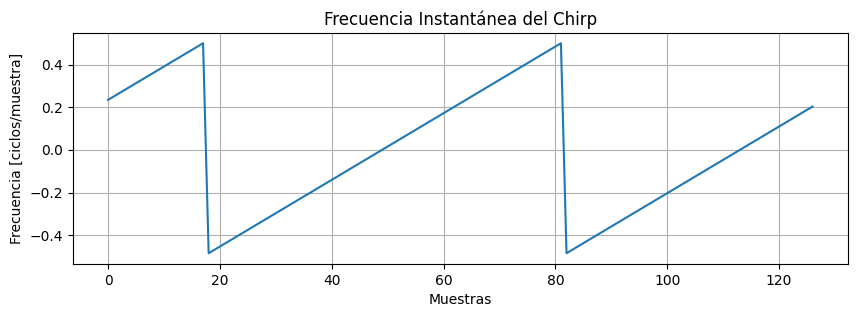

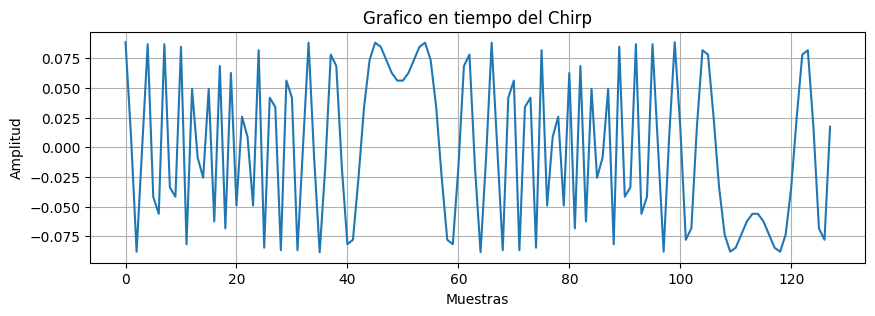

In [89]:
# Generar un chirp
# Calcular fase y frecuencia instantánea
chirp_tx_aux = waveform_former(simbolo_tx, SF, 1/ Bw, Bw)[0]  #Seleccionamos el primer chirp generado
fase = np.unwrap(np.angle(chirp_tx_aux))        #Calcula la fase de la señal compleja y hacemos uso de unwrap para evitar saltos discontinuos.
frecuencia_inst = np.diff(fase) / (2 * np.pi)   #Calcula la diferencia entre cada valor de fase consecutivo y luego dividimos por 2π para normalizar el resultado.

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(frecuencia_inst)
plt.title("Frecuencia Instantánea del Chirp")
plt.xlabel("Muestras")
plt.ylabel("Frecuencia [ciclos/muestra]")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(chirp_tx_aux[:2**SF])
plt.title("Grafico en tiempo del Chirp")
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

In [111]:
def upchirp(SF, T, Bw):
    M_local = 2**SF  
    sobremuestreo = 1/(Bw*T)
    k = np.arange(M_local*sobremuestreo)
    fase = (k/sobremuestreo) * (k*T*Bw) / M_local
    chirp = (1 / np.sqrt(M_local)) * np.exp(1j * 2 * np.pi * fase)
    return chirp

In [112]:
def downchirp(SF, T, Bw):
    return np.conj(upchirp(SF, T, Bw))

##  n-Tuple Former

###  Sección III del paper de Vangelista

La detección del símbolo transmitido se realiza implementado un receptor óptimo (n-Tuple Former). 

1. Se multiplica el chirp recibido por una señal conjugada de referencia conocida como "downchirp":
   $\begin{aligned}
   d(k) = e^{-j2\pi \cdot \frac{k^2}{2^{SF}}}
   \end{aligned}$
2. Se aplica una Transformada Rápida de Fourier (FFT) al producto.
3. Se detecta el símbolo como el índice del valor máximo del espectro resultante.


###  Análisis Matemático

Para cada chirp recibido $\begin{aligned} r(k) \end{aligned}$, se realiza:

$\begin{aligned}
d(k) &= r(k) \cdot e^{-j2\pi \cdot \frac{k^2}{2^{SF}}} \\
R(f) &= \text{FFT}\left\{ d(k) \right\} \\
\hat{s} &= \arg \max_{f} \left| R(f) \right|
\end{aligned}$

Donde:
- $\begin{aligned} r(k) \end{aligned}$: chirp recibido de longitud $\begin{aligned} M = 2^{SF} \end{aligned}$
- $\begin{aligned} d(k) \end{aligned}$: señal desmodulada en base al downchirp
- $\begin{aligned} R(f) \end{aligned}$: transformada espectral
- $\begin{aligned} \hat{s} \end{aligned}$: símbolo estimado

En el libro "Bixio Rimoldi-Principles of Digital Communication" Sección 3.4 (página 102, Figura 3.4): Define el n-Tuple Former como el receptor que toma R(t) y produce la n-tupla Y, nuestra implementación usa la propiedad especial de los chirps donde la multiplicación por el downchirp seguida de FFT es equivalente a proyectar sobre una base ortonormal (los chirps desplazados en frecuencia).

<img src='Recursos\g2.png'>


In [ ]:
def n_tuple_former(chirps_recibidos, SF, T, Bw):
    producto = chirps_recibidos * downchirp(SF, T, Bw)  # Multiplicación punto a punto
    fft_producto = np.fft.fft(producto, axis=1)
    simbolos_estimados = np.argmax(np.abs(fft_producto), axis=1)  # La función np.argmax() de la biblioteca NumPy devuelve el índice del valor máximo dentro de un array. Se busca el impulso mas grande en el espectro de frecuencia y nos quedamos con el indice.

    return simbolos_estimados


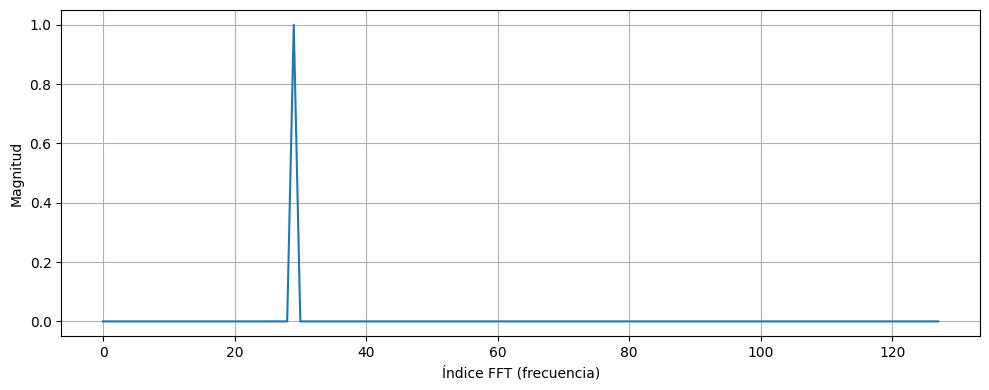

In [93]:
# Producto chirp con downchirp
produc = chirp_tx_aux * downchirp(SF, 1, 1)
fft_result = np.fft.fft(produc)
magnitud = np.abs(fft_result)

# Graficar la magnitud de la FFT
plt.figure(figsize=(10, 4))
plt.plot(magnitud)
plt.xlabel("Índice FFT (frecuencia)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.show()

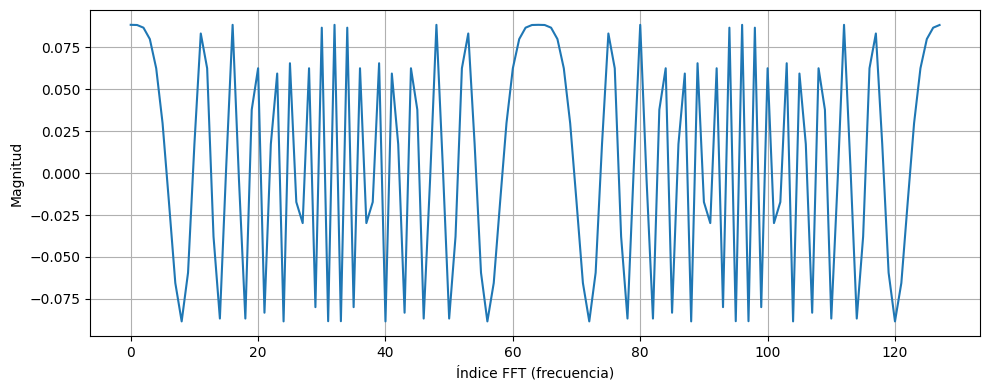

In [94]:
plt.figure(figsize=(10, 4))
plt.plot(np.real(downchirp(7, 1, 1)))
plt.xlabel("Índice FFT (frecuencia)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.show()

### Tasa de Error de Símbolos (SER)

Mide la frecuencia con la que un símbolo completo se recibe de forma incorrecta.


In [95]:
def ser(s_tx, s_rx):
    return np.mean(s_rx != s_tx)

In [96]:
simbolo_tx = coder(bits_tx, SF)
chirp_tx = waveform_former(simbolo_tx, SF, 1, 1)
simbolo_rx = n_tuple_former(chirp_tx, SF, 1, 1)

print("Símbolos transmitidos:", simbolo_tx)
print("Símbolos decodificados:", simbolo_rx)
print("SER:", ser(simbolo_tx, simbolo_rx))

Símbolos transmitidos: [ 29  77 110  48 111  84 110  62 108  40  45  30  64  75  47  66  96  67
   1  33  24   5  36  32 115  71  49   5 107 126 119 103  20 122 125   7
 112  48  22  83  40  98  93 127   3  54  40  94  60   3  69  44  29  78
  26  67  74 111  72  80 110  40  18  64  91 108  39  38  56  25  42  98
   3  34  17   0  29  61  98  30  49  25  23 110  74  37  71  49  30  98
  49  23  33  25  42  55  55   4 104  33]
Símbolos decodificados: [ 29  77 110  48 111  84 110  62 108  40  45  30  64  75  47  66  96  67
   1  33  24   5  36  32 115  71  49   5 107 126 119 103  20 122 125   7
 112  48  22  83  40  98  93 127   3  54  40  94  60   3  69  44  29  78
  26  67  74 111  72  80 110  40  18  64  91 108  39  38  56  25  42  98
   3  34  17   0  29  61  98  30  49  25  23 110  74  37  71  49  30  98
  49  23  33  25  42  55  55   4 104  33]
SER: 0.0


##  Canal con Ruido AWGN

### AWGN (Additive White Gaussian Noise)
Según la Sección IV del paper, el sistema puede ser evaluado bajo un modelo de canal con ruido aditivo blanco gaussiano complejo (AWGN).
Es un modelo de canal donde el ruido se suma a la señal transmitida:
- Media: 0
- Varianza: $\begin{aligned} \sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{lineal}}}=\frac{N_o}{2}\end{aligned}$


Donde:

$\begin{aligned}
\text{SNR}_{\text{lineal}} = 10^{\frac{\text{SNR}_{dB}}{10}}
\end{aligned}$



### Procedimiento:
1. Se genera una señal chirp (modulada) por símbolo.
2. Se suma ruido Gaussiano complejo a la señal transmitida.



In [ ]:
def agregacion_AWNG(chirp_tx, snr_db):
    chirp_tx_normalizado = chirp_tx / np.sqrt(np.mean(np.abs(chirp_tx)**2, axis=1, keepdims=True))  # Normalizamos el chirp transmitido para que su potencia que ingrese a la etapa de ruido sea 1
    snr_lineal = (10**(snr_db / 10.0))
    potencia_ruido_N0 = 1.0 / snr_lineal
    sigma = np.sqrt(potencia_ruido_N0 / 2.0) 
    ruido_complejo = np.random.normal(0, sigma, size=chirp_tx.shape) +1j * np.random.normal(0, sigma, size=chirp_tx.shape)
    return chirp_tx_normalizado + ruido_complejo


### Relacion entre BER y SER

Un único error de símbolo puede causar uno o más errores de bit. Por esta razón la Tasa de Error de Símbolos (SER) siempre será mayor o igual que la Tasa de Error de Bits (BER).

In [98]:
Bw = 1
T = 1/Bw  

bits_tx = np.random.randint(0, 2, size=10000*SF)
simbolos_tx = coder(bits_tx, SF)
chirps_tx = waveform_former(simbolos_tx, SF, T, Bw)
chirps_rx_con_ruido = agregacion_AWNG(chirps_tx, -10)   # Ejemplo con SNR = -10 dB
simbolos_rx = n_tuple_former(chirps_rx_con_ruido, SF, T, Bw)
bits_rx = decoder(simbolos_rx, SF)

print("Símbolos transmitidos:", simbolos_tx)
print("Símbolos decodificados:", simbolos_rx)

print(f"BER: {ber(bits_tx, bits_rx)}")
print(f"SER: {ser(simbolos_tx, simbolos_rx)}")

Símbolos transmitidos: [ 79  68 123 ...  25 103  54]
Símbolos decodificados: [ 79  68 123 ...  25 103  54]
BER: 0.019685714285714286
SER: 0.0381


## Canal Selectivo en Frecuencia


En la Sección IV del paper de Vangelista, se modela un canal selectivo en frecuencia mediante una respuesta al impulso discreta definida como:

$\begin{aligned}
h(nT) = \sqrt{0.8} \cdot \delta(nT) + \sqrt{0.2} \cdot \delta(nT - T)
\end{aligned}$

Este canal tiene dos trayectorias:

- Una trayectoria directa con ganancia $\begin{aligned} \sqrt{0.8} \end{aligned}$  (80% de la potencia de la señal)
- Una trayectoria secundaria con ganancia $\begin{aligned} \sqrt{0.2} \end{aligned}$ (20% de la potencia de la señal) con un desplazamiento en $\begin{aligned} T \end{aligned}$.

Dado que cada chirp tiene $\begin{aligned} M = 2^{\text{SF}} \end{aligned}$ muestras, se implementa el canal como una convolución discreta entre la señal transmitida y un vector $\begin{aligned} h \end{aligned}$ con dos picos:

$\begin{aligned}
h[n] =
\begin{cases}
\sqrt{0.8}, & n = 0 \\
\sqrt{0.2}, & n = T \\
0, & \text{en otro caso}
\end{cases}
\end{aligned}$



In [99]:
def canal_selectivo_frecuencia(chirps, SF):
    h = [np.sqrt(0.8), np.sqrt(0.2)]
    signal_con_canal = np.zeros_like(chirps, dtype=complex)

    for i in range(chirps.shape[0]):       
        chirp_individual = chirps[i]    # Aplicar el canal a un solo chirp usando convolución
        chirp_con_canal = np.convolve(chirp_individual, h, mode='same')  #La convolución produce un array de longitud M 
        signal_con_canal[i] = chirp_con_canal  
    return signal_con_canal

### Visualizacion de curvas BER y SER - FLAT FSCM

Teniendo en cuenta el grafico del paper de Vangelista nos muestra que en $-7dB$ tiene un BER de $7.10^{-5}$ BER. Esto nos dice que se espera 7 bits errados cada 100000 bits enviados. Para calcular la cantidad de bits a enviar en nuestra simulacion y tener un BER similar a Vangelista debemos realizar aproximadamente 140000 bits.

$7 \longrightarrow 100000$\
$10 \longrightarrow \frac{10.100000}{7} {\simeq 142000}$

<img src='Recursos\image.png'>

Valor para BER (-10 dB) Vangelista = 0.02 \
Valor para BER (-10 dB) Simulado = 0.019


BER( -10 dB):  0.018764285714285716 SER( -10 dB):  0.03675
BER( -9 dB):  0.005464285714285714 SER( -9 dB):  0.0108
BER( -8 dB):  0.0010857142857142858 SER( -8 dB):  0.00185
BER( -7 dB):  5.714285714285714e-05 SER( -7 dB):  0.0001


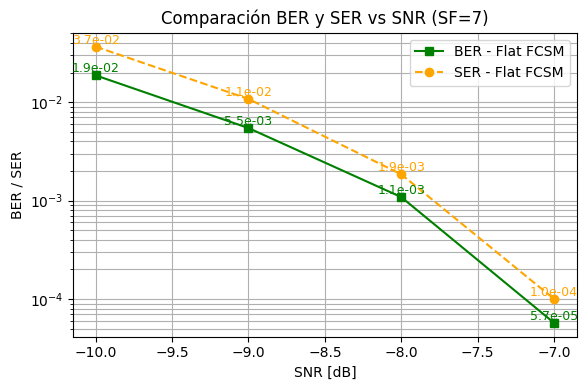

In [106]:
#N_bits_por_punto = 400000 * SF
N_bits_por_punto = 20000 * SF
snr_db_range = np.arange(-10, -6, 1)
ber_resultados = []
ser_resultados = []

for snr_db in snr_db_range:
    bits_tx = np.random.randint(0, 2, size=N_bits_por_punto)
    simbolos_tx = coder(bits_tx, SF)
    chirps_tx = waveform_former(simbolos_tx, SF, 1, 1)
    chirps_rx_con_ruido = agregacion_AWNG(chirps_tx, snr_db)
    simbolos_rx = n_tuple_former(chirps_rx_con_ruido, SF, 1, 1)
    bits_rx = decoder(simbolos_rx, SF)
    current_ber = ber(bits_tx, bits_rx)
    current_ser = ser(simbolos_tx, simbolos_rx)
    print("BER(",snr_db,"dB): ", current_ber,"SER(",snr_db,"dB): " ,current_ser)
    ber_resultados.append(current_ber)
    ser_resultados.append(current_ser)

plt.figure(figsize=(6, 4))
plt.semilogy(snr_db_range, ber_resultados, linestyle='-', marker='s', color='green', label='BER - Flat FCSM')
for x, y in zip(snr_db_range, ber_resultados):
    plt.text(x, y, f"{y:.1e}", fontsize=9, ha='center', va='bottom', color='green')
plt.semilogy(snr_db_range, ser_resultados, linestyle='--', marker='o', color='orange', label='SER - Flat FCSM')
for x, y in zip(snr_db_range, ser_resultados):
    plt.text(x, y, f"{y:.1e}", fontsize=9, ha='center', va='bottom', color='orange')

plt.xlabel("SNR [dB]")
plt.ylabel("BER / SER")
plt.title(f"Comparación BER y SER vs SNR (SF={SF})")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()


### Visualizacion de curvas BER y SER - FREQ.SEL. FSCM

Teniendo en cuenta el grafico del paper de Vangelista nos muestra que en $-3dB$ tiene un BER de $5.10^{-5}$ BER. Esto nos dice que se espera 5 bits errados cada 100000 bits enviados. Para calcular la cantidad de bits a enviar en nuestra simulacion y tener un BER similar a Vangelista debemos realizar aproximadamente 203000 bits.

$5 \longrightarrow 100000$\
$10 \longrightarrow \frac{10.100000}{5} {\simeq 203000}$

<img src='Recursos\image.png'>

Valor para BER (-8 dB) Vangelista = 0.0098 \
Valor para BER (-8 dB) Simulado = 0.0095

BER( -8 dB):  0.009552380952380953 SER( -8 dB):  0.028833333333333332
BER( -7 dB):  0.003819047619047619 SER( -7 dB):  0.013066666666666667
BER( -6 dB):  0.0014952380952380953 SER( -6 dB):  0.0056
BER( -5 dB):  0.000580952380952381 SER( -5 dB):  0.002266666666666667
BER( -4 dB):  0.0002476190476190476 SER( -4 dB):  0.0008333333333333334
BER( -3 dB):  4.761904761904762e-05 SER( -3 dB):  0.0002


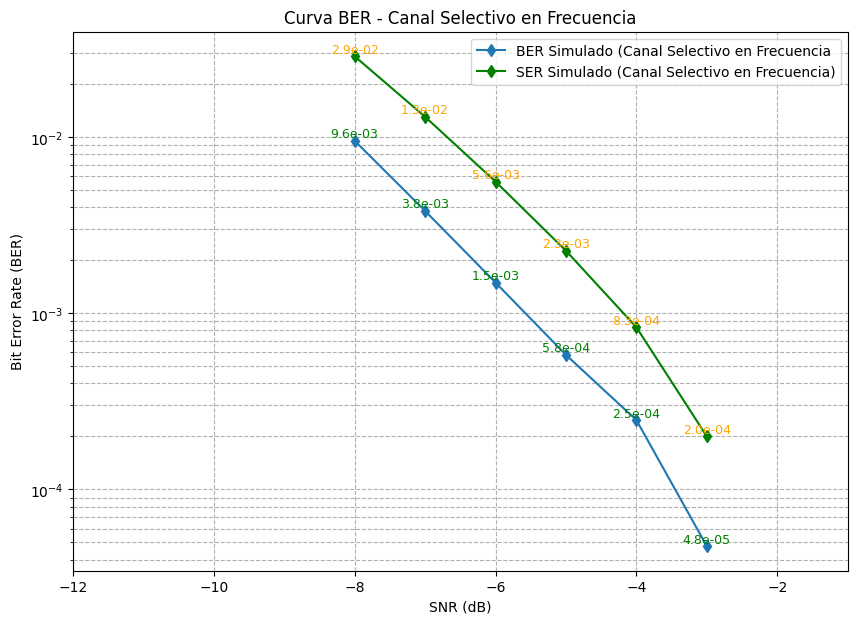

In [107]:
#N_bits_por_punto = 800000 * SF
N_bits_por_punto = 30000 * SF
snr_db_range = np.arange(-8, -2, 1)
ber_resultados = []
ser_resultados = []

for snr_db in snr_db_range:
    bits_tx = np.random.randint(0, 2, size=N_bits_por_punto)
    simbolos_tx = coder(bits_tx, SF)
    chirps_tx = waveform_former(simbolos_tx, SF, 1, 1)
    chirps_con_canal = canal_selectivo_frecuencia(chirps_tx, SF)
    chirps_rx_con_ruido = agregacion_AWNG(chirps_con_canal, snr_db)
    simbolos_rx = n_tuple_former(chirps_rx_con_ruido, SF, 1, 1)
    bits_rx = decoder(simbolos_rx, SF)
    current_ber = ber(bits_tx, bits_rx)
    current_ser = ser(simbolos_tx, simbolos_rx)
    print("BER(",snr_db,"dB): ", current_ber,"SER(",snr_db,"dB): " ,current_ser)
    ber_resultados.append(current_ber)
    ser_resultados.append(current_ser)

# Gráfico de BER y SER
plt.figure(figsize=(10, 7))
plt.semilogy(snr_db_range, ber_resultados, 'd-', label=f'BER Simulado (Canal Selectivo en Frecuencia')
for x, y in zip(snr_db_range, ber_resultados):
    plt.text(x, y, f"{y:.1e}", fontsize=9, ha='center', va='bottom', color='green') 
plt.semilogy(snr_db_range, ser_resultados, 'd-', color='green', label='SER Simulado (Canal Selectivo en Frecuencia)')
for x, y in zip(snr_db_range, ser_resultados):
    plt.text(x, y, f"{y:.1e}", fontsize=9, ha='center', va='bottom', color='orange')
plt.title('Curva BER - Canal Selectivo en Frecuencia')
plt.xlabel('SNR (dB)'); plt.ylabel('Bit Error Rate (BER)')
plt.xlim(-12, -1)
plt.grid(True, which="both", ls="--");
plt.legend()
plt.show()

## Transmisión de Tramas LoRa


Según el paper "From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation", la estructura de una trama LoRa estándar consta de **tres componentes principales** que forman la base de la comunicación LoRa completa.

#### Estructura de Paquete LoRa

La **Figura 3** del paper muestra que un paquete LoRa estándar tiene la siguiente estructura temporal:

**Paquete LoRa = Preámbulo + SFD + Símbolos de Datos**

#### 1. **Preámbulo (Preamble)**

El preámbulo es una secuencia de **up-chirps base** que cumple funciones críticas:

- **Función de Sincronización**: Permite al receptor detectar la presencia de un paquete LoRa
- **Estimación de Canal**: Facilita la sincronización temporal y la estimación de parámetros de canal
- **Detección de Energía**: Establece un nivel de referencia para la detección

**Características técnicas:**
- Consiste en $N_p$ up-chirps base (típicamente 8)
- Cada up-chirp base corresponde al símbolo $s = 0$
- Señal matemática: $c_{base}(k) = \frac{1}{\sqrt{M}} e^{j2\pi \frac{k^2}{M}}$ para $k = 0, 1, \ldots, M-1$

#### 2. **SFD (Start Frame Delimiter)**

El SFD actúa como **marcador de inicio** de los datos:

- **Función**: Indica de manera precisa el comienzo de los símbolos de datos
- **Estructura**: Consiste en **2.25 down-chirps**
- **Importancia**: Permite la sincronización exacta entre transmisor y receptor. El receptor detecta el cambio de pendiente de up-chirps (+) a down-chirps (-) y el 0.25 (1/4) de chirp final proporciona un marcador temporal preciso.

**Características técnicas:**
- 2 down-chirps completos + 1/4 de down-chirp adicional
- Down-chirp: $d(k) = \frac{1}{\sqrt{M}} e^{-j2\pi \frac{k^2}{M}}$
- Total de muestras del SFD: $2.25 \times M = 2M + \frac{M}{4}$

#### 3. **Símbolos de Datos (Payload)**

Los símbolos de datos (Payload) transportan la información útil del paquete. Cada símbolo LoRa codifica SF bits de información mediante un chirp desplazado cíclicamente.


In [108]:
def build_tx_frame(simbolos_data, SF, preamble_len=8):
    M  = 2**SF
    up = upchirp(SF, 1, 1)          # up-chirp s=0 (forma discreta típica)                                     # down-chirp
    down = downchirp(SF,1 ,1)

    # preámbulo: Np up-chirps
    pre = np.tile(up, preamble_len) #Repite el up-chirp 'preamble_len' veces

    # SFD: 2 + 1/4 down-chirps (2.25)
    sfd = np.concatenate([np.tile(down, 2), down[:M//4]]) #repite 2 veces el down-chirp y luego agrega un cuarto de down-chirp

    # payload (matriz símbolos → vector)
    payload = waveform_former(simbolos_data, SF, 1, 1).flatten() #Concatena los chirps generados en un solo vector              

    trama = np.concatenate([pre, sfd, payload])

    return trama

In [109]:
def visualizar_estructura_trama(frame, simbolos_data, SF, preamble_len=8):

    M = 2**SF

    # Calcular longitudes de cada sección
    len_preamble = preamble_len * M
    len_sfd = int(2.25 * M)
    len_payload = len(simbolos_data) * M
    len_total = len_preamble + len_sfd + len_payload

    # Índices de delimitación
    idx_sfd_start = len_preamble
    idx_payload_start = len_preamble + len_sfd

    # Verificar longitud de la trama
    print("ESTRUCTURA DE LA TRAMA LoRa")
    print(f"SF = {SF}, M = {M}")
    print(f"\nLongitudes esperadas:")
    print(f"Preámbulo ({preamble_len} up-chirps): {len_preamble} muestras")
    print(f"SFD (2.25 down-chirps):  {len_sfd} muestras")
    print(f"Payload ({len(simbolos_data)} símbolos): {len_payload} muestras")
    print(f"TOTAL: {len_total} muestras")
    print(f"\nLongitud real de la trama: {len(frame)} muestras")
    print(f"Diferencia: {len(frame) - len_total} muestras")
    print(f"\nSímbolos del payload: {simbolos_data}")

    # GRÁFICO 1: Estructura temporal completa (parte real) 
    fig, ax = plt.subplots(figsize=(15, 4))

    t = np.arange(len(frame))
    ax.plot(t, np.real(frame), linewidth=0.5, color='blue', alpha=0.7)

    # Marcadores verticales
    ax.axvline(idx_sfd_start, color='red', linestyle='--', linewidth=2, label='Inicio SFD')
    ax.axvline(idx_payload_start, color='green', linestyle='--', linewidth=2, label='Inicio Payload')

    # Sombreado de regiones
    ax.axvspan(0, idx_sfd_start, alpha=0.2, color='cyan', label='Preámbulo')
    ax.axvspan(idx_sfd_start, idx_payload_start, alpha=0.2, color='yellow', label='SFD')
    ax.axvspan(idx_payload_start, len(frame), alpha=0.2, color='lightgreen', label='Payload')

    ax.set_xlabel('Muestras')
    ax.set_ylabel('Amplitud (Parte Real)')
    ax.set_title('Estructura Completa de la Trama LoRa')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # GRÁFICO 2: Frecuencia instantánea de toda la trama 
    fase = np.unwrap(np.angle(frame))
    frec_inst = np.diff(fase) / (2 * np.pi)

    fig, ax = plt.subplots(figsize=(15, 5))

    t_frec = np.arange(len(frec_inst))
    ax.plot(t_frec, frec_inst, linewidth=0.8, color='darkblue')

    # Marcadores verticales
    ax.axvline(idx_sfd_start, color='red', linestyle='--', linewidth=2, label='Inicio SFD')
    ax.axvline(idx_payload_start, color='green', linestyle='--', linewidth=2, label='Inicio Payload')

    # Sombreado de regiones
    ax.axvspan(0, idx_sfd_start, alpha=0.15, color='cyan')
    ax.axvspan(idx_sfd_start, idx_payload_start, alpha=0.15, color='yellow')
    ax.axvspan(idx_payload_start, len(frame), alpha=0.15, color='lightgreen')

    # Anotaciones
    ax.text(len_preamble/2, ax.get_ylim()[1]*0.9, 'PREÁMBULO\n(up-chirps)', ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.5))
    ax.text(idx_sfd_start + len_sfd/2, ax.get_ylim()[1]*0.9, 'SFD\n(down-chirps)', ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    ax.text(idx_payload_start + len_payload/2, ax.get_ylim()[1]*0.9, 'PAYLOAD\n(datos)', ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    ax.set_xlabel('Muestras')
    ax.set_ylabel('Frecuencia Normalizada [ciclos/muestra]')
    ax.set_title('Frecuencia Instantánea - Verificación de Estructura LoRa')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

Generando trama de prueba...
ESTRUCTURA DE LA TRAMA LoRa
SF = 7, M = 128

Longitudes esperadas:
Preámbulo (8 up-chirps): 1024 muestras
SFD (2.25 down-chirps):  288 muestras
Payload (5 símbolos): 640 muestras
TOTAL: 1952 muestras

Longitud real de la trama: 1952 muestras
Diferencia: 0 muestras

Símbolos del payload: [  5  23  90 100 100]


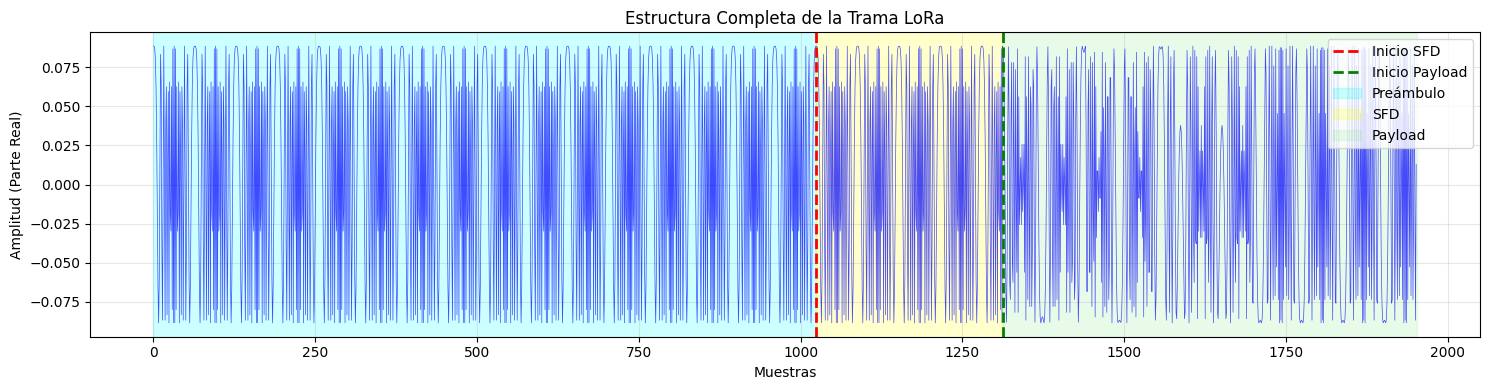

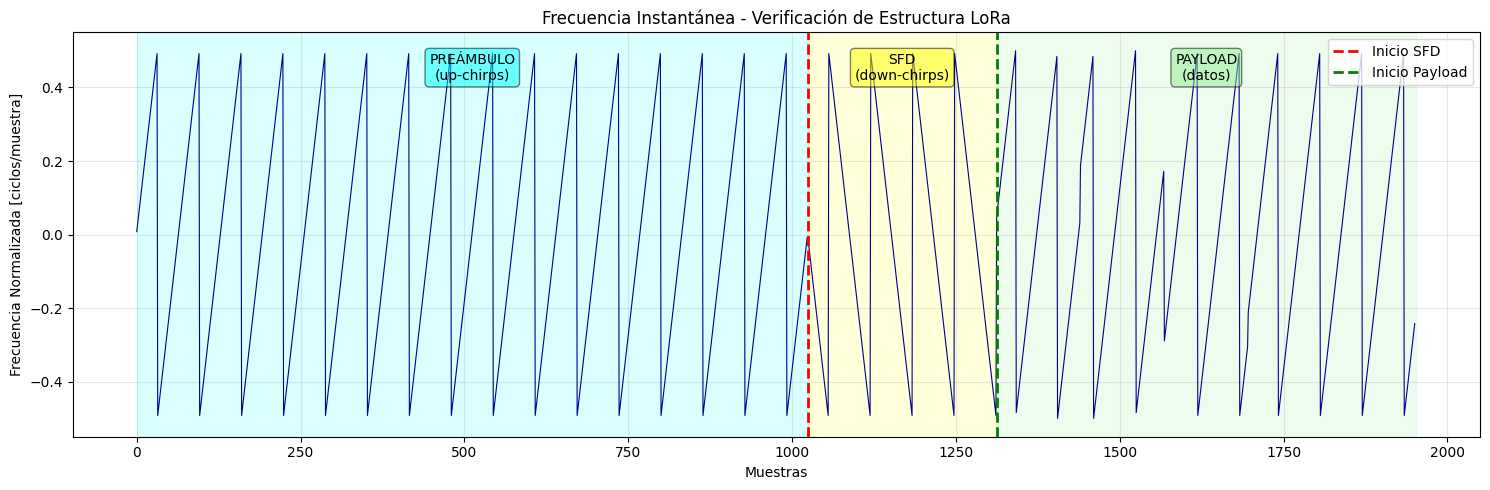

In [110]:
# ==== EJEMPLO DE USO: Visualización de estructura de trama ====

# Generar trama de prueba
SF_test = 7
M_test = 2**SF_test
simbolos_test = np.array([5, 23, 90, 100, 100])

print("Generando trama de prueba...")
trama_test = build_tx_frame(simbolos_test, SF_test, preamble_len=8)

# Visualizar estructura completa
visualizar_estructura_trama(trama_test, simbolos_test, SF_test, preamble_len=8)